# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M42_event/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## Event M42
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:20")
config['tend'] = obs.UTCDateTime("2022-12-31 12:12:55")

# config['fmin'] = 1
# config['fmax'] = 5.0

## Load Data

In [4]:
event = Client("USGS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

## Eventtime
config['eventtime'] = event.origins[0].time

In [5]:
st0 = obs.read("./event42_6c.mseed")

# for tr in st0:
#     if "BSPF" in tr.stats.station:
#         tr.data = np.roll(tr.data, -10)

submask = "mid"

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location="mi").copy()

In [6]:
# ##load rotation
# bspf0, bspf_inv = __request_data("PY.BSPF..HJ*", config['tbeg'], config['tend'])
# bspf0.resample(40);

# ## load translation
# pfo0, pfo_inv = __request_data("II.PFO.10.BH*", config['tbeg'], config['tend'], translation_type="ACC")

# ## ADR
# submask = "mid"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)

## merge to one stream
# st0 = bspf0.copy();
# st0 += adr0.copy();
# st0 += pfo0.copy();

# st0.trim(config['tbeg']+1, config['tend']-1)

# # st0.plot(equal_scale=False);

## Create stream for all data

In [7]:
def __makeplot_waveform_comparison(bspf, adr, submask):

    fig, ax = plt.subplots(3, 1, figsize=(15,5))

    font = 14

    ax[0].plot(bspf.select(channel="*Z")[0].times(), bspf.select(channel="*Z")[0].data, label="BSPF Z")
    ax[0].plot(adr.select(channel="*Z")[0].times(), adr.select(channel="*Z")[0].data, label="ADR Z")

    ax[1].plot(bspf.select(channel="*N")[0].times(), bspf.select(channel="*N")[0].data, label="BSPF N")
    ax[1].plot(adr.select(channel="*N")[0].times(), adr.select(channel="*N")[0].data, label="ADR N")

    ax[2].plot(bspf.select(channel="*E")[0].times(), bspf.select(channel="*E")[0].data, label="BSPF E")
    ax[2].plot(adr.select(channel="*E")[0].times(), adr.select(channel="*E")[0].data, label="ADR E")


    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("rot. rate (rad/s)")

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask}")

    plt.show();
    return fig

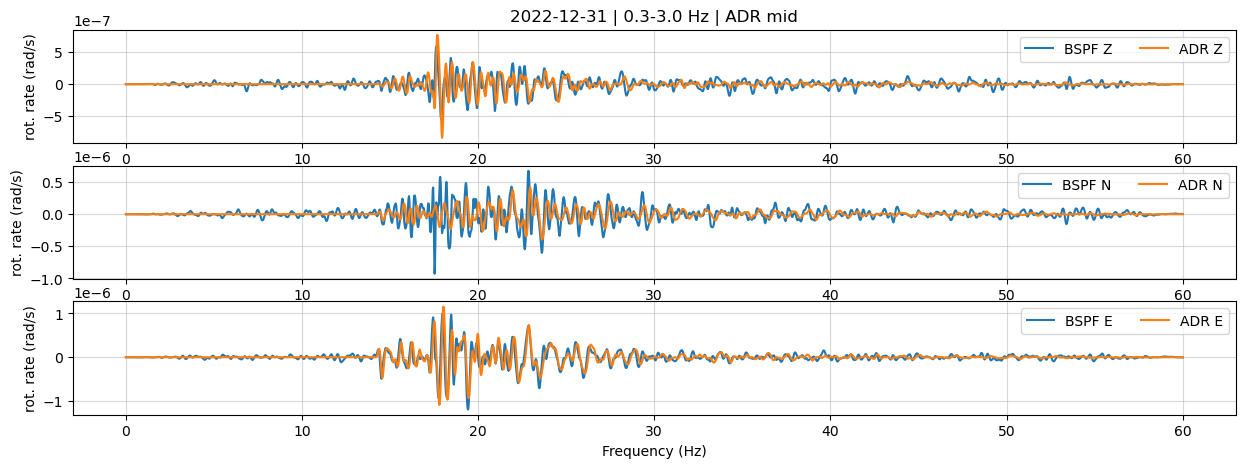

In [8]:
config['fmin'] = 0.3
config['fmax'] = 3.0


bspf = bspf0.copy()
bspf = bspf.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])

adr = adr0.copy()
adr = adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax']);

pfo = pfo0.copy()
pfo = pfo.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])


# for tr in bspf:
#     tr.data = np.roll(tr.data, 2)


fig = __makeplot_waveform_comparison(bspf, adr, submask)

fig.savefig(config['path_to_figs']+f"BSPF_M42_waveforms_{submask}.png", format="png", dpi=200, bbox_inches='tight');

In [9]:
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:16.653700Z - 2022-12-31T12:13:16.653700Z | 40.0 Hz, 2401 samples
PY.BSPF..HJN | 2022-12-31T12:12:16.653800Z - 2022-12-31T12:13:16.653800Z | 40.0 Hz, 2401 samples
PY.BSPF..HJZ | 2022-12-31T12:12:16.653800Z - 2022-12-31T12:13:16.653800Z | 40.0 Hz, 2401 samples

9 Trace(s) in Stream:
II.RPFO.al.BJE | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.al.BJN | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.al.BJZ | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.in.BJE | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.in.BJN | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.in.BJZ | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mi.BJE | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mi.BJN | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mi.BJZ | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples

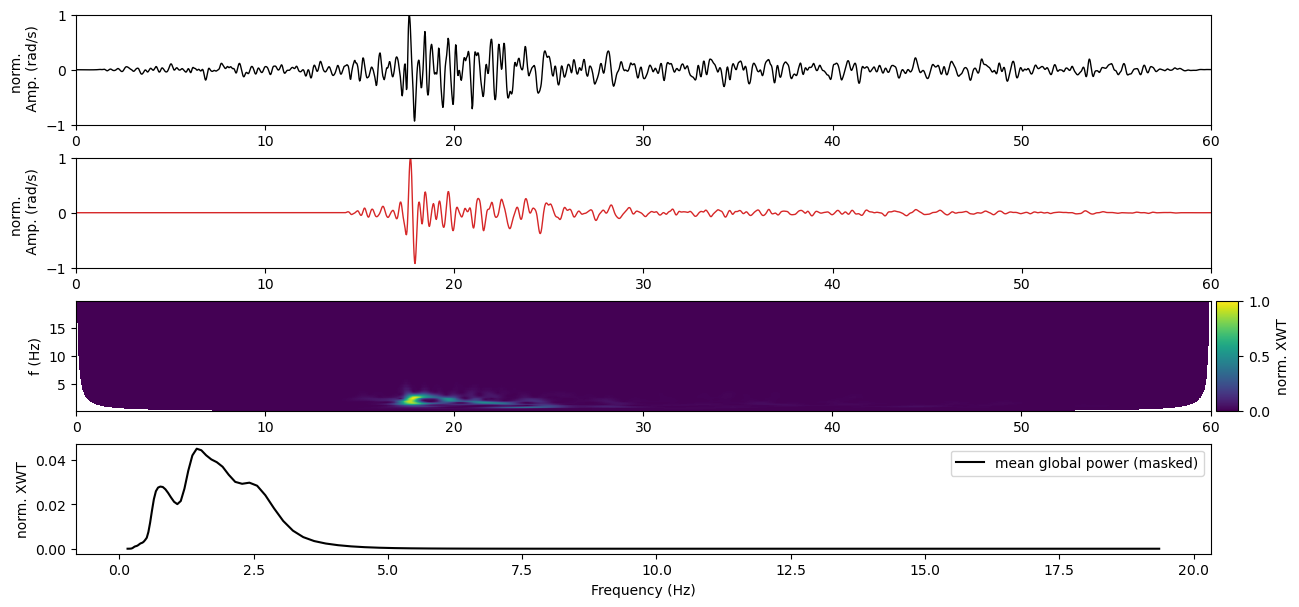

In [10]:
acc = st0.select(station="PFO*").copy().detrend("demean")
rot = st0.select(station="BSPF").copy().detrend("demean")
adr = st0.select(station="RPFO").copy().detrend("demean")

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])
adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])


comp = "Z"

out = __compute_cross_wavelet_transform(
                                    rot[0].times(),
                                    rot.select(channel=f"*{comp}")[0].data,
                                    adr.select(channel=f"*{comp}")[0].data,
                                    rot[0].stats.delta,
                                    xwt_threshold=0.,
                                    normalize=True,
                                    plot=True,
)

## Backazimuth

In [11]:
from functions.compute_backazimuth import __compute_backazimuth

In [12]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = config['fmin'], config['fmax']

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)


# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:16.653700Z - 2022-12-31T12:13:16.653700Z | 40.0 Hz, 2401 samples
PY.BSPF..HJN | 2022-12-31T12:12:16.653800Z - 2022-12-31T12:13:16.653800Z | 40.0 Hz, 2401 samples
PY.BSPF..HJZ | 2022-12-31T12:12:16.653800Z - 2022-12-31T12:13:16.653800Z | 40.0 Hz, 2401 samples

3 Trace(s) in Stream:
II.PFO.10.BHE | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples

In [13]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

In [14]:
# out = __compute_backazimuth(
#                             acc,
#                             rot,
#                             config,
#                             wave_type='love',
#                             event=event,
#                             plot=True,
#                             flim=(fmin, fmax),
#                             show_details=False,
# )

# out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_love_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [15]:
# out = __compute_backazimuth(
#                             acc,
#                             rot,
#                             config,
#                             wave_type='rayleigh',
#                             event=event,
#                             plot=True,
#                             flim=(fmin, fmax),
#                             show_details=False,
# )

# out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_rayleigh_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [16]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth

In [17]:
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')

In [18]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [19]:
# def __compute_backazimuth_tangent(rot0, acc0, win_time_s=0.5, overlap=0.5, baz_theo=None, cc_thres=None, plot=False):

#     from numpy import zeros, nan, ones, nanmean, array, nanmax
#     from numpy import arctan, pi, linspace, cov, argsort, corrcoef, correlate
#     from obspy.signal.rotate import rotate_ne_rt
#     from numpy.linalg import eigh
#     from obspy.signal.cross_correlation import correlate
#     import matplotlib.pyplot as plt

#     npts = rot0[0].stats.npts

#     df = rot0[0].stats.sampling_rate

#     ## windows
#     t_win = win_time_s
#     n_win = int(win_time_s*df)
#     nover = int(overlap*n_win)

#     ## extract components
#     rot_n = rot0.select(channel="*N")[0].data
#     rot_e = rot0.select(channel="*E")[0].data
#     acc_z = acc0.select(channel="*Z")[0].data

#     ## define windows
#     n, windows = 0, []
#     while n < npts-n_win:
#         windows.append((n,n+n_win))
#         n+=n_win


#     ## add overlap
#     if overlap != 0:
#         windows_overlap = []
#         for i, w in enumerate(windows):
#             if i == 0:
#                 windows_overlap.append((w[0], w[1]+nover))
#             elif i >= int(len(windows)-nover):
#                 windows_overlap.append((w[0]-nover, w[1]))
#             else:
#                 windows_overlap.append((w[0]-nover, w[1]+nover))
#     else:
#         windows_overlap = windows

#     ## compute baz and ccorr for each window
#     baz, ccor = ones(len(windows_overlap))*nan, ones(len(windows_overlap))*nan

#     for j, (w1, w2) in enumerate(windows_overlap):

#         if int(w2-w1) < 10:
#             print(f" -> not enough samples in window (<10)")

#         dat = (zeros((len(rot_n[w1:w2]), 2)))
#         dat[:, 0] = rot_e[w1: w2]
#         dat[:, 1] = rot_n[w1: w2]

#         covar = cov(dat, rowvar=False)

#         Cprime, Q = eigh(covar, UPLO='U')

#         loc = argsort(abs(Cprime))[::-1]

#         Q = Q[:, loc]

#         baz0 = -arctan((Q[1, 0]/Q[0, 0]))*180/pi

#         if baz0 <= 0:
#             baz0 += 180

#         ## __________________________
#         ## remove 180° ambiguity

#         rot_r, rot_t = rotate_ne_rt(rot_n[w1:w2], rot_e[w1:w2], baz0)

#         # corr_baz = corrcoef(acc_z[w1:w2], rot_t)[0][1]
#         corr_baz = correlate(acc_z[w1:w2], rot_t, 0, 'auto')[0]

#         if (corr_baz > 0): ## original
#             baz0 += 180

#         ## add new values to array
#         # if abs(corr_baz) > cc_thres:
#         #     baz[j] = baz0
#         #     ccor[j] = corr_baz  ## original
#         baz[j] = baz0
#         ccor[j] = abs(corr_baz) ## new abs()


#     ## define time axis
#     t1 = array([w1/df for (w1, w2) in windows_overlap])
#     t2 = array([w2/df for (w1, w2) in windows_overlap])

#     time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
#     terr = (t2-t1)/2

#     win_center = array([(((w2-w1)/2)+w1) for (w1, w2) in windows_overlap])
#     t_win_center = win_center/df


#     ## Plotting
#     if plot:

#         rot0_r, rot0_t = rotate_ne_rt(rot_n, rot_e, baz_theo)

#         cmap = plt.get_cmap("viridis", 10)

#         fig, ax = plt.subplots(1, 1, figsize=(15,5))

#         ax.plot(array(range(len(rot0_t)))/df, rot0_t/max(abs(rot0_t)), alpha=1, color="grey", label="rotation rate T (rad/s)")
#         ax.plot(array(range(len(acc_z)))/df, acc_z/max(abs(acc_z)), alpha=0.5, color="tab:red", label=r"acceleration Z (m/s$^2$)")


#         ax.set_ylim(-1, 1)
#         # ax.set_xlim(0, len(rot0_t)/df)
#         ax.set_xlabel("Time (s)", fontsize=14)
#         ax.set_ylabel("Norm. Amplitude", fontsize=14)
#         ax.grid(zorder=0)
#         ax.legend(loc=4, fontsize=13)

#         ax2 = ax.twinx()
#         cax = ax2.scatter(time, baz, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax2.errorbar(time, baz, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
#         ax2.set_ylabel("Backazimuth (°)", fontsize=14)
#         ax2.set_ylim(0, 360)
#         ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

#         cbar = plt.colorbar(cax, pad=0.08)
#         cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

#         cax.set_clip_on(False)

#         if baz_theo:
#             ax2.axhline(baz_theo, ls=":", c="k")

#         plt.show();

#         out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo, "t_win_center":t_win_center, "fig":fig}
#     else:
#         out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo, "t_win_center":t_win_center}

#     return out

In [20]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = 0.5, 2.0
# fmin, fmax = config['fmin'], config['fmax']


rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

# for tr in rot:
#     tr.data = np.roll(tr.data, -10)

# for tr in acc:
#     if "*Z" in tr.stats.channel:
#         tr.data *= -1

# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:16.653700Z - 2022-12-31T12:13:16.653700Z | 40.0 Hz, 2401 samples
PY.BSPF..HJN | 2022-12-31T12:12:16.653800Z - 2022-12-31T12:13:16.653800Z | 40.0 Hz, 2401 samples
PY.BSPF..HJZ | 2022-12-31T12:12:16.653800Z - 2022-12-31T12:13:16.653800Z | 40.0 Hz, 2401 samples

3 Trace(s) in Stream:
II.PFO.10.BHE | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ | 2022-12-31T12:12:16.644538Z - 2022-12-31T12:13:16.644538Z | 40.0 Hz, 2401 samples

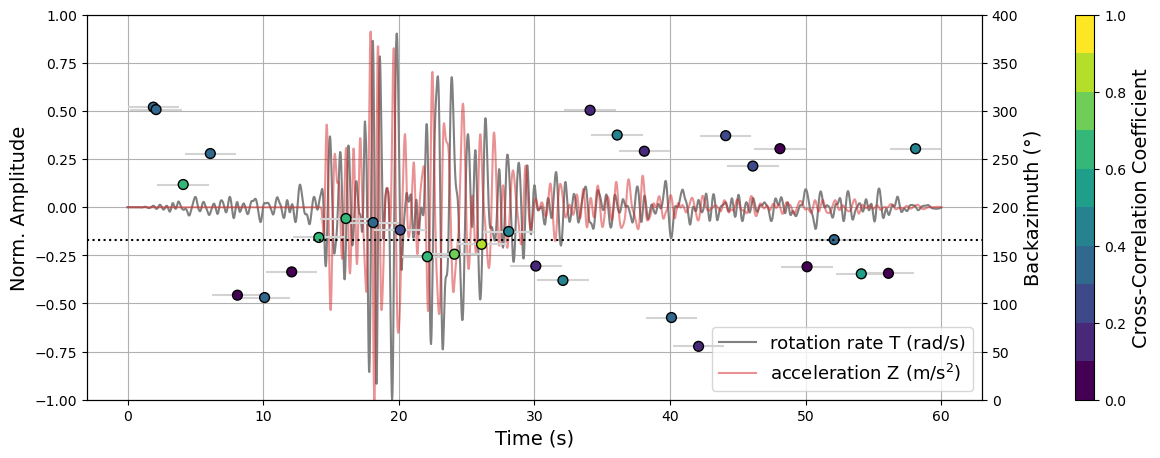

In [21]:
out = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=1/fmin,
                                    overlap=0.9,
                                    baz_theo=baz,
                                    cc_thres=0,
                                    plot=True,
                                    )

# out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_baz_tangent_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Compare Backazimuth Codes

In [22]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [23]:
# def __compare_backazimuth_codes(rot, acc, cat_event, fmin, fmax, cc_thres=None, plot=False):

#     import scipy.stats as sts
#     import matplotlib.pyplot as plt

#     from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange
#     from obspy import UTCDateTime
#     from functions.compute_backazimuth import __compute_backazimuth
#     from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
    
    
#     rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
#     acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

#     config = {}

#     config['tbeg'] = rot[0].stats.starttime
#     config['tend'] = rot[0].stats.endtime

#     ## Eventtime
#     config['eventtime'] = UTCDateTime(cat_event.origins[0].time)

#     ## specify coordinates of station
#     config['station_longitude'] =  -116.455439
#     config['station_latitude']  = 33.6106

#     ## specify window length for baz estimation in seconds
#     config['win_length_sec'] = 1/fmin

#     ## define an overlap for the windows in percent (50 -> 50%)
#     config['overlap'] = 50

#     ## specify steps for degrees of baz
#     config['step'] = 1


#     out1 = __compute_backazimuth(
#                                 acc,
#                                 rot,
#                                 config,
#                                 wave_type='rayleigh',
#                                 event=cat_event,
#                                 plot=False,
#                                 flim=(fmin, fmax),
#                                 show_details=False,
#     )

#     out2 = __compute_backazimuth(
#                                 acc,
#                                 rot,
#                                 config,
#                                 wave_type='love',
#                                 event=cat_event,
#                                 plot=False,
#                                 flim=(fmin, fmax),
#                                 show_details=False,
#     )

#     out3 = __compute_backazimuth_tangent(
#                                         rot,
#                                         acc,
#                                         win_time_s= config['win_length_sec'],
#                                         overlap=config['overlap']/100,
#                                         baz_theo=out2['baz_theo'],
#                                         cc_thres=0,
#                                         plot=False,
#     )

#     ## filter according to cc-threshold
#     if cc_thres:
#         for ii, _cc in enumerate(out1['cc_max']):
#             if _cc <= cc_thres:
#                 out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
#         for ii, _cc in enumerate(out2['cc_max']):
#             if _cc <= cc_thres:
#                 out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
#         for ii, _cc in enumerate(out3['ccoef']):
#             if _cc <= cc_thres:
#                 out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



#     if plot:

#         NN = 6
#         rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
#         trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

#         font = 12

#         fig1, ax = plt.subplots(NN, 1, figsize=(15, 10), sharex=True)

#         plt.subplots_adjust(hspace=0.2)

#         hz = acc.select(channel="*HZ")[0]
#         hn = acc.select(channel="*HN")[0]
#         he = acc.select(channel="*HE")[0]

#         jz = rot.select(channel="*JZ")[0]
#         jn = rot.select(channel="*JN")[0]
#         je = rot.select(channel="*JE")[0]

#         t1, t2 = hz.times().min(), hz.times().max()

#         ax[0].plot(hz.times(), hz.data*trans_scaling, 'black', label=f"XPFO.Z")
#         ax[1].plot(hn.times(), hn.data*trans_scaling, 'black', label=f"XPFO.N")
#         ax[2].plot(he.times(), he.data*trans_scaling, 'black', label=f"XPFO.E")

#         ax[0].set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))
#         ax[1].set_ylim(-max(abs(hn.data*trans_scaling)), max(abs(hn.data*trans_scaling)))
#         ax[2].set_ylim(-max(abs(he.data*trans_scaling)), max(abs(he.data*trans_scaling)))

#         ax00 = ax[0].twinx()
#         ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

#         ax11 = ax[1].twinx()
#         ax11.plot(jn.times(), jn.data*rot_scaling, 'darkred', label=r"BSPF.N")

#         ax22 = ax[2].twinx()
#         ax22.plot(je.times(), je.data*rot_scaling, 'darkred', label=r"BSPF.E")

#         ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
#         ax11.set_ylim(-max(abs(jn.data*rot_scaling)), max(abs(jn.data*rot_scaling)))
#         ax22.set_ylim(-max(abs(je.data*rot_scaling)), max(abs(je.data*rot_scaling)))

#         cmap = plt.get_cmap("viridis", 10)

#         ca3 = ax[3].scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax[3].plot([t1, t2], ones(2)*out1['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

#         ca4 = ax[4].scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax[4].plot([t1, t2], ones(2)*out2['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

#         ca5 = ax[5].scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax[5].plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

#         cax3 = ax[3].inset_axes([1.01, 0., 0.02, 1])
#         cb3 = plt.colorbar(ca3, ax=ax[3], cax=cax3)
#         cb3.set_label("CC-Coeff.", fontsize=font)

#         cax4 = ax[4].inset_axes([1.01, 0., 0.02, 1])
#         cb4 = plt.colorbar(ca4, ax=ax[4], cax=cax4)
#         cb4.set_label("CC-Coeff.", fontsize=font)

#         cax5 = ax[5].inset_axes([1.01, 0., 0.02, 1])
#         cb5 = plt.colorbar(ca5, ax=ax[5], cax=cax5)
#         cb5.set_label("CC-Coeff.", fontsize=font)

#         ax[3].set_ylabel(f"Rayleigh Baz.(°)")
#         ax[4].set_ylabel(f"Love Baz.(°)")
#         ax[5].set_ylabel(f"CoVar. Baz.(°)")


#         ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
#         ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

#         ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
#         ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

#         ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
#         ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

#         for i in [0,1,2]:
#             ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
#             ax[i].legend(loc=1)
#             ax[i].set_ylabel(f"a ({trans_unit})")

#         for i in [3,4,5]:
#             ax[i].set_ylim(-5, 365)
#             ax[i].set_yticks(range(0,360+60,60))
#             ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
#             # ax[i].set_ylabel(f"Baz.(°)")

#         for aaxx in [ax00, ax11, ax22]:
#             aaxx.tick_params(axis='y', colors="darkred")
#             aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
#             aaxx.legend(loc=4)

#         ax[0].set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % ")

#         plt.show();



#     ## compute statistics
#     deltaa = 10
#     angles = arange(0, 365, deltaa)

#     ## ______________________________________
#     ## Rayleigh
#     baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
#     cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

#     hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

#     baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
#     baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

#     # baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
#     kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=baz_rayleigh_no_nan)
#     baz_rayleigh_max = angles[argmax(kde1.pdf(angles))] + deltaa

#     ## ______________________________________
#     ## Love
#     baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
#     cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

#     hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

#     baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
#     baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

#     # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
#     kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)
#     baz_love_max = angles[argmax(kde2.pdf(angles))] + deltaa

#     ## ______________________________________
#     ## Tangent
#     baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
#     cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

#     hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

#     baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
#     baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

#     # baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
#     kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)
#     baz_tangent_max = angles[argmax(kde3.pdf(angles))] + deltaa

#     if plot:

#         fig2, ax = plt.subplots(1, 3, figsize=(15, 5))

#         ax[0].hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)
#         ax[0].plot(angles, kde1.pdf(angles), c='C1', lw=2, label='KDE')
#         ax[0].axvline(baz_rayleigh_max, color="r")
#         ax[0].axvline(baz_rayleigh_mean, color="g")
#         ax[0].set_title("Rayleigh")
#         ax[0].set_xlabel("Backazimuth")
#         ax[0].set_ylabel("Density")

#         ax[1].hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)
#         ax[1].plot(angles, kde2.pdf(angles), c='C1', lw=2, label='KDE')
#         ax[1].axvline(baz_love_max, color="r")
#         ax[1].axvline(baz_love_mean, color="g")
#         ax[1].set_title("Love")
#         ax[1].set_xlabel("Backazimuth")

#         ax[2].hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)
#         ax[2].plot(angles, kde3.pdf(angles), c='C1', lw=2, label='KDE')
#         ax[2].axvline(baz_tangent_max, color="r")
#         ax[2].axvline(baz_tangent_mean, color="g")
#         ax[2].set_title("Co.Var.")
#         ax[2].set_xlabel("Backazimuth")
#         plt.show();


#     ## prepare output directory
#     out = {}
#     out['baz_theo'] = round(out2['baz_theo'], 0)
#     out['baz_angles'] = angles
#     out['baz_tangent_max'] = baz_tangent_max
#     out['baz_tangent_mean'] = baz_tangent_mean
#     out['baz_tangent_std'] = baz_tangent_std
#     out['baz_rayleigh_max'] = baz_rayleigh_max
#     out['baz_rayleigh_mean'] = baz_rayleigh_mean
#     out['baz_rayleigh_std'] = baz_rayleigh_std
#     out['baz_love_max'] = baz_love_max
#     out['baz_love_mean'] = baz_love_mean
#     out['baz_love_std'] = baz_love_std


#     if plot:
#         out['fig1'] = fig1
#         out['fig2'] = fig2

#     return out

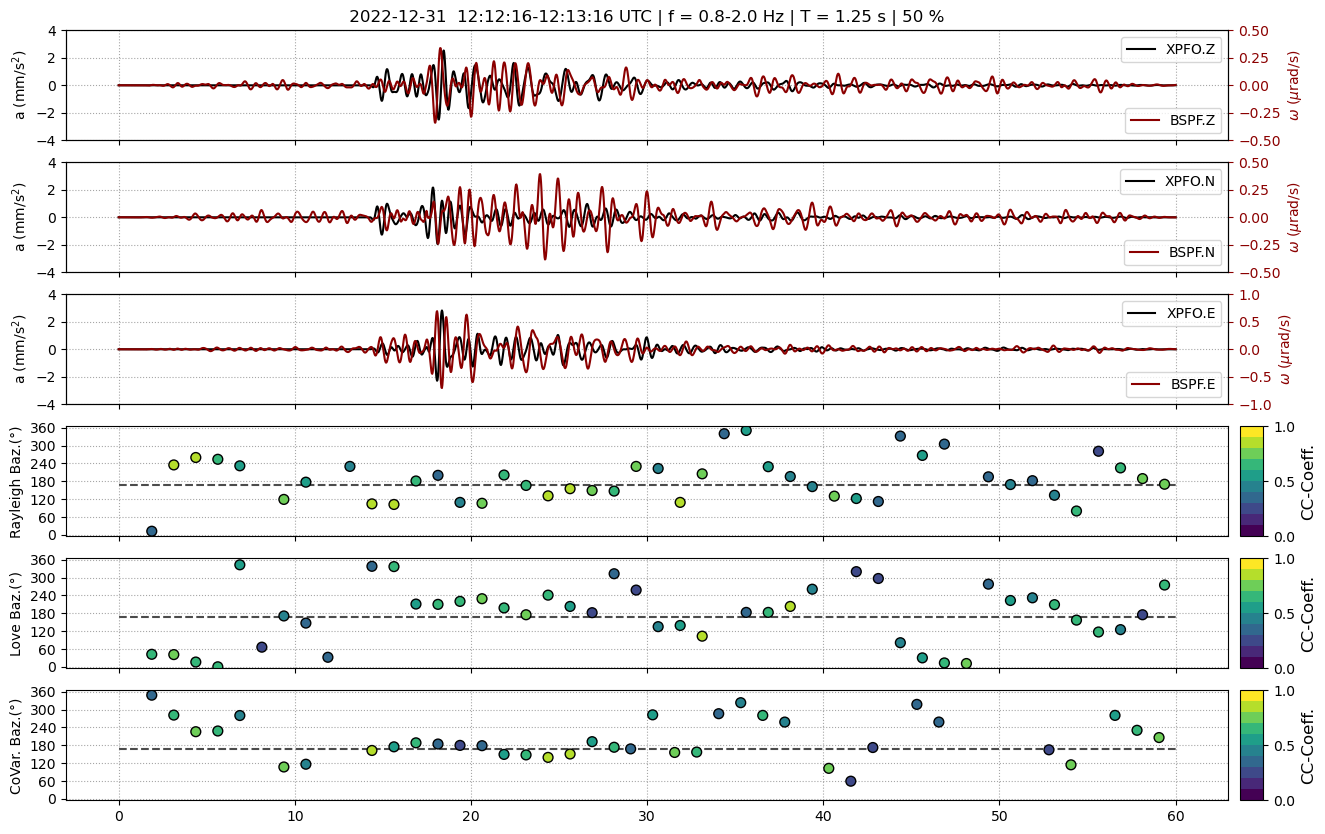

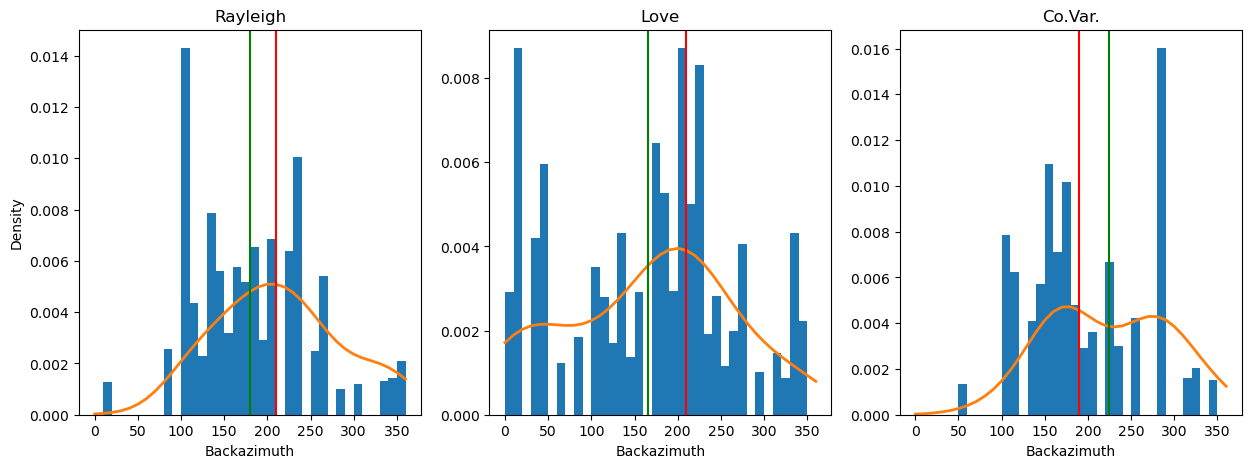

In [24]:
st = st0.copy();

acc = st.select(station="PFO*");
rot = st.select(station="BSPF");
# rot = st.select(station="RPFO", location="in");
# rot = st.select(station="RPFO", location="mi");
# rot = st.select(station="RPFO", location="al");

# for tr in rot:
#     tr.data = np.roll(tr.data, -10)


# fmin, fmax = config['fmin'], config['fmax']
fmin, fmax = 0.8, 2.0

out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.2, plot=True);

out['fig1'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
out['fig2'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_his2.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [25]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [26]:
# def __compute_beamforming_pfo(tbeg, tend, submask, fmin=None, fmax=None, component="", bandpass=True, plot=False):

#     import os
#     import numpy as np
#     import timeit
#     import matplotlib.pyplot as plt
#     import matplotlib.dates as mdates

#     from obspy import UTCDateTime, Stream
#     from obspy.clients import fdsn
#     from obspy.geodetics.base import gps2dist_azimuth
#     from obspy.geodetics import locations2degrees
#     from obspy.clients.fdsn import Client, RoutingClient
#     from obspy.signal import array_analysis as AA
#     from obspy.signal.util import util_geo_km
#     from obspy.signal.rotate import rotate2zne
#     from obspy.core.util import AttribDict
#     from obspy.imaging.cm import obspy_sequential
#     from obspy.signal.invsim import corn_freq_2_paz
#     from obspy.signal.array_analysis import array_processing    
#     from datetime import datetime
#     from matplotlib.colorbar import ColorbarBase
#     from matplotlib.colors import Normalize

#     import warnings
#     warnings.filterwarnings('ignore')

#     ## _____________________________________________________

#     def __get_data(config):

#         config['subarray'] = []

#         st = Stream()

#         for k, station in enumerate(config['subarray_stations']):

#             net, sta = station.split(".")

#             if net == "II" and sta == "PFO":
#                 loc, cha = "10", "BH*"
#             elif net == "PY" and sta == "PFOIX":
#                 loc, cha = "", "HH*"
#             else:
#                 loc, cha = "", "BH*"

#             # print(f" -> requesting {net}.{sta}.{loc}.{cha}")


#             ## querry inventory data
#             # try:
#             inventory = config['fdsn_client'].get_stations(
#                                                              network=net,
#                                                              station=sta,
#                                                              # channel=cha,
#                                                              starttime=config['tbeg']-20,
#                                                              endtime=config['tend']+20,
#                                                              level="response"
#                                                             )
#             # except:
#             #     print(f" -> {station}: Failed to load inventory!")
#             #     inventory = None

#             ## try to get waveform data
#             try:
#                 stats = config['fdsn_client'].get_waveforms(
#                                                             network=net,
#                                                             station=sta,
#                                                             location=loc,
#                                                             channel=cha,
#                                                             starttime=config['tbeg']-20,
#                                                             endtime=config['tend']+20,
#                                                             attach_response=True
#                                                             )
#             except Exception as E:
#                 print(E) if config['print_details'] else None
#                 print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
#                 continue


#             ## merge if masked
#             if len(stats) > 3:
#                 print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
#                 stats.merge(method=1, fill_value="interpolate")


#             ## sorting
#             # stats.sort().reverse()


#             ## remove response [ACC -> m/s/s | VEL -> m/s | DISP -> m]
#             stats.remove_response(inventory=inventory, output="VEL")


#             ## rotate to ZNE
#             try:
#                 stats.rotate(method="->ZNE", inventory=inventory)
#             except:
#                 print(" -> failed to rotate to ZNE")
#                 continue


#             #correct mis-alignment
#             # stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0], 0, -90,
#             #                                                          stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0,
#             #                                                          stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


#             ## trim to interval
#             # stats.trim(config['tbeg'], config['tend'], nearest_sample=False)



#             ## rename channels
#             # if net == "II" and sta == "PFO":
#             #     for tr in stats:
#             #         if tr.stats.channel[-1] == "1":
#             #             tr.stats.channel = str(tr.stats.channel).replace("1","E")
#             #         if tr.stats.channel[-1] == "2":
#             #             tr.stats.channel = str(tr.stats.channel).replace("2","N")

#             if config['reference_station'] == "PY.PFOIX":
#                 stats = stats.resample(40)
#                 stats = stats.trim(config['tbeg']-20, config['tend']+20)


#             if station == config['reference_station']:
#                 ref_station = stats.copy()

#             st += stats


#         print(st.__str__(extended=True)) if config['print_details'] else None

#         ## update subarray stations if data could not be requested for all stations
#         if len(st) < 3*len(config['subarray_stations']):
#             config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
#             config['subarray_stations'] = list(set(config['subarray_stations']))

#         print(f" -> obtained: {int(len(st)/3)} of {len(config['subarray_stations'])} stations!")

#         if len(st) == 0:
#             return st, config
#         else:
#             return st, config


#     def __add_coordinates(st, config):

#         coo = []
#         for i, station in enumerate(config['subarray_stations']):

#             net, sta = station.split(".")

#             if net == "II" and sta == "PFO":
#                 loc, cha = "10", "BH*"
#             elif net == "PY" and sta == "PFOIX":
#                 loc, cha = "", "HH*"
#             else:
#                 loc, cha = "", "BH*"

#             try:
#                 inven = config['fdsn_client'].get_stations(network=net,
#                                                            station=sta,
#                                                            channel=cha,
#                                                            starttime=config['tbeg'],
#                                                            endtime=config['tend'],
#                                                            level='response'
#                                                           )
#             except:
#                 print(f" -> cannot get inventory for {station}")

#             l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
#             l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
#             height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

#             ## set coordinates of seismometer manually, since STATIONXML is wrong...
#             if sta == "XPFO" or sta == "PFO" or sta == "PFOIX":
#                 l_lon, l_lat =  -116.455439, 33.610643


#             for c in ["Z", "N", "E"]:
#                 st.select(station=sta, channel=f"*{c}")[0].stats.coordinates = AttribDict({
#                                                                                           'latitude': l_lat,
#                                                                                           'elevation': height/1000,
#                                                                                           'longitude': l_lon
#                                                                                            })

#         return st

#     ## _____________________________________________________

#     ## start timer for runtime
#     start_timer = timeit.default_timer()


#     ## _____________________________________________________

#     ## generate configuration object
#     config = {}

#     ## time period of event
#     config['tbeg'] = UTCDateTime(tbeg)
#     config['tend'] = UTCDateTime(tend)

#     ## select the fdsn client for the stations
#     config['fdsn_client'] = Client('IRIS')


#     ## select stations to consider:
#     ## all: [0,1,2,3,4,5,6,7,8,9,10,11,12] | optimal: [0,5,8,9,10,11,12] | inner: [0,1,2,3]
#     if submask is not None:
#         if submask == "inner":
#             config['subarray_mask'] = [0,1,2,3,4]
#             config['freq1'] = 0.16  ## 0.00238*3700/100
#             config['freq2'] = 16.5 ## 0.25*3700/100
#         elif submask == "mid":
#             config['subarray_mask'] = [0,1,2,3,4,5,6,7,8]
#             config['freq1'] = 0.03   ## 0.00238*3700/280
#             config['freq2'] = 3.3 # 0.25*3700/280
#         elif submask == "all":
#             config['subarray_mask'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
#             config['freq1'] = 0.02   ## 0.00238*3700/700
#             config['freq2'] = 1.3 # 0.25*3700/700
#     else:
#         config['subarray_mask'] = [0,1,2,3,4]


#     ## decide if information is printed while running the code
#     config['print_details'] = False

#     ## apply bandpass to data
#     config['apply_bandpass'] = bandpass


#     ## _____________________
#     ## PFO array information

#     if config['tbeg'] > UTCDateTime("2023-04-01"):
#         config['reference_station'] = 'PY.PFOIX' ## 'BPH01'  ## reference station

#         config['array_stations'] = ['PY.PFOIX','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
#                                     'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']
#     else:
#         config['reference_station'] = 'II.PFO' ## 'BPH01'  ## reference station

#         config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
#                                     'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


#     config['misorientations'] =  [0, 0. ,-1.375 ,0.25 ,0.125 ,-0.6875 ,-0.625 ,-1.9375 ,0.375
#                                   ,-6.5625 ,0.3125 ,-1.125 ,-2.5625 ,0.1875]


#     config['subarray_misorientation'] = [config['misorientations'][i] for i in config['subarray_mask']]
#     config['subarray_stations'] = [config['array_stations'][i] for i in config['subarray_mask']]

#     ## ______________________________

#     ## beamforming parameters
#     config['slow_xmin'] = -0.5
#     config['slow_xmax'] = 0.5
#     config['slow_ymin'] = -0.5
#     config['slow_ymax'] = 0.5
#     config['slow_steps'] = 0.01

#     config['win_length'] = 1/fmin # window length in seconds
#     config['win_frac'] = 0.5  # fraction of window to use as steps

#     config['freq_lower'] = fmin
#     config['freq_upper'] = fmax
#     config['prewhitening'] = 0  ## 0 or 1


#     ## loading data
#     st, config = __get_data(config)

#     ## pre-pprocessing data
#     st = st.detrend("demean")

#     if config['apply_bandpass']:
#         st = st.taper(0.1)
#         st = st.filter("bandpass", freqmin=config['freq_lower'], freqmax=config['freq_upper'], corners=8, zerophase=True)

#     ## add coordinates from inventories
#     st = __add_coordinates(st, config)

#     ## select only one component
#     st = st.select(channel=f"*{component}")

#     st = st.trim(config['tbeg']-0.1, config['tend']+0.1)

#     ## define parameters for beamforming
#     kwargs = dict(

#         # slowness grid: X min, X max, Y min, Y max, Slow Step
#         sll_x=config['slow_xmin'], slm_x=config['slow_xmax'],
#         sll_y=config['slow_ymin'], slm_y=config['slow_ymax'],
#         sl_s=config['slow_steps'],

#         # sliding window properties
#         win_len=config['win_length'], win_frac=config['win_frac'],

#         # frequency properties
#         frqlow=config['freq_lower'], frqhigh=config['freq_upper'], prewhiten=config['prewhitening'],

#         # restrict output
#         semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',

#         ## time period
#         stime=config['tbeg'], etime=config['tend'],
#         # stime=st[0].stats.starttime, etime=st[0].stats.endtime,
#     )

#     ## perform beamforming
#     out = array_processing(st, **kwargs)

#     st = st.trim(config['tbeg'], config['tend'])


#     ## stop times
#     stop_timer = timeit.default_timer()
#     print(f"\n -> Runtime: {round((stop_timer - start_timer)/60,2)} minutes")

#     ## ______________________________
#     ## Plotting

#     if plot:

#         ## PLOT 1 -----------------------------------
#         labels = ['rel.power', 'abs.power', 'baz', 'slow']

#         out[:, 3][out[:, 3] < 0.0] += 360

#         xlocator = mdates.AutoDateLocator()

#         fig1, ax = plt.subplots(5,1, figsize=(15,10))

#         Tsec = config['tend']-config['tbeg']
#         times = (out[:, 0]-out[:, 0][0]) / max(out[:, 0]-out[:, 0][0]) * Tsec

#         for i, lab in enumerate(labels):
#             # ax[i].scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
#             # ax[i].scatter(times, out[:, i + 1], c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
#             ax[i].scatter(times, out[:, i + 1], c=out[:, 2], alpha=0.6, edgecolors='k', cmap=obspy_sequential)
#             ax[i].set_ylabel(lab)
#             # ax[i].set_xlim(out[0, 0], out[-1, 0])
#             ax[i].set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
#             ax[i].xaxis.set_major_locator(xlocator)
#             ax[i].xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

#         ax[4].plot(st[0].times()/st[0].times()[-1]*out[:, 0][-1], st[0].data)
#         ax[2].set_ylim(0, 360)

#         fig1.autofmt_xdate()

#         plt.show();



#     ## PLOT 2 -----------------------------------
#     cmap = obspy_sequential

#     # make output human readable, adjust backazimuth to values between 0 and 360
#     t, rel_power, abs_power, baz, slow = out.T
#     baz[baz < 0.0] += 360

#     # choose number of fractions in plot (desirably 360 degree/N is an integer!)
#     N = 36
#     N2 = 30
#     abins = np.arange(N + 1) * 360. / N
#     sbins = np.linspace(0, 3, N2 + 1)


#     # sum rel power in bins given by abins and sbins
#     # hist2d, baz_edges, sl_edges = np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)
#     hist2d, baz_edges, sl_edges = np.histogram2d(baz, slow, bins=[abins, sbins], weights=abs_power)

#     # transform to radian
#     baz_edges = np.radians(baz_edges)

#     if plot:

#         # add polar and colorbar axes
#         fig2 = plt.figure(figsize=(8, 8))

#         cax = fig2.add_axes([0.85, 0.2, 0.05, 0.5])
#         ax = fig2.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
#         ax.set_theta_direction(-1)
#         ax.set_theta_zero_location("N")

#         dh = abs(sl_edges[1] - sl_edges[0])
#         dw = abs(baz_edges[1] - baz_edges[0])

#         # circle through backazimuth
#         for i, row in enumerate(hist2d):
#             bars = ax.bar((i * dw) * np.ones(N2),
#                           height=dh * np.ones(N2),
#                           width=dw, bottom=dh * np.arange(N2),
#                           color=cmap(row / hist2d.max()))

#         ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
#         ax.set_xticklabels(['N', 'E', 'S', 'W'])

#         # set slowness limits
#         ax.set_ylim(0, config['slow_xmax'])
#         [i.set_color('grey') for i in ax.get_yticklabels()]
#         ColorbarBase(cax, cmap=cmap, norm=Normalize(vmin=hist2d.min(), vmax=hist2d.max()))

#         plt.show();

#     max_val = 0
#     for i in range(hist2d.shape[0]):
#         for j in range(hist2d.shape[1]):
#             if hist2d[i,j] > max_val:
#                 max_val, slw_max, baz_max = hist2d[i,j], sbins[j], abins[i]

#     ## prepare output
#     baz = out[:, 3]
#     baz[baz < 0.0] += 360

#     ## compute statistics
#     deltaa = 5
#     angles = np.arange(0, 365, deltaa)

#     hist = np.histogram(baz, bins=len(angles)-1, range=[min(angles), max(angles)], weights=out[:, 2], density=False)

#     baz_bf_mean = round(np.average(baz[~np.isnan(baz)], weights=out[:, 2][~np.isnan(out[:, 2])]), 0)
#     baz_bf_std = np.sqrt(np.cov(baz[~np.isnan(baz)], aweights=out[:, 2][~np.isnan(out[:, 2])]))
#     baz_bf_max = angles[np.argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center


#     output = {}
#     output['t_win'] = out[:, 0]
#     output['rel_pwr'] = out[:, 1]
#     output['abs_pwr'] = out[:, 2]
#     output['baz'] = baz
#     output['slow'] = out[:, 4]
#     output['baz_max_count'] = max_val
#     output['baz_max'] = baz_max
#     output['slw_max'] = slw_max
#     output['baz_bf_mean'] = baz_bf_mean
#     output['baz_bf_max'] = baz_bf_max
#     output['baz_bf_std'] = baz_bf_std


#     if plot:
#         output['fig1'] = fig1
#         output['fig2'] = fig2

#     return output

In [ ]:
st = st0.copy();

acc = st.select(station="PFO*").copy();

## ____________________
## direct rotation
rot = st.select(station="BSPF").copy();
out_bspf_i = __compare_backazimuth_codes(rot, acc, event, fmin=1.0, fmax=12.0, cc_thres=0.2, plot=False);

rot = st.select(station="BSPF").copy();
out_bspf_m = __compare_backazimuth_codes(rot, acc, event, fmin=0.5, fmax=2.0, cc_thres=0.2, plot=False);

rot = st.select(station="BSPF").copy();
out_bspf_a = __compare_backazimuth_codes(rot, acc, event, fmin=0.3, fmax=1.0, cc_thres=0.2, plot=False);

rot = st.select(station="BSPF").copy();
out_bspf_o = __compare_backazimuth_codes(rot, acc, event, fmin=0.8, fmax=2.0, cc_thres=0.2, plot=False);

## ____________________
## adr rotation
rot = st.select(station="RPFO", location="in").copy();
out_adr_i = __compare_backazimuth_codes(rot, acc, event, fmin=1.0, fmax=12.0, cc_thres=0.2, plot=False);

rot = st.select(station="RPFO", location="mi").copy();
out_adr_m = __compare_backazimuth_codes(rot, acc, event, fmin=0.5, fmax=2.0, cc_thres=0.2, plot=False);

rot = st.select(station="RPFO", location="al").copy();
out_adr_a = __compare_backazimuth_codes(rot, acc, event, fmin=0.3, fmax=1.0, cc_thres=0.2, plot=False);

rot = st.select(station="RPFO", location="al").copy();
out_adr_o = __compare_backazimuth_codes(rot, acc, event, fmin=0.8, fmax=2.0, cc_thres=0.2, plot=False);

## ____________________
## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=1.0, fmax=12.0, component="Z", submask="inner", plot=False)
out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=2.0, component="Z", submask="mid", plot=False)
out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.3, fmax=1.0, component="Z", submask="all", plot=False)
out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=2.0, component="Z", submask="mid", plot=False)


 -> obtained: 5 of 5 stations!

 -> Runtime: 0.32 minutes


In [ ]:
def __makeplot_comparison():

    labels = ["BSPF-i", "ADR-i", "BF-i", "BSPF-m", "ADR-m", "BF-m", "BSPF-a", "ADR-a", "BF-a", "BSPF", "ADR", "BF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--")

    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a, out_adr_o]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        if j == 0:
            ax.legend(loc=1)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a, out_bspf_o]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a, out_bf_o]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")


    ax.set_ylim(0, 360)

    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4,3,3.2,3.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "1.0 - 12.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 3.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.3 - 1.0 Hz", fontsize=font-1)
    ax.text(3, 360+10, "0.8 - 2.0 Hz", fontsize=font-1)


    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 3.8)

    plt.show();
    return fig

In [ ]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Cross Spectral Density

In [ ]:
def __makeplotStream_csd2(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,14))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[] 
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
                
        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        bspf_inner.normalize()
        
        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        adr_inner.normalize()
        
        nseg = int(5*tmp[0].stats.sampling_rate)
        
        ff, Pxy = csd(  
                        bspf_inner.data,
                        adr_inner.data,
                        fs=bspf_inner.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='density',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)
        
        ## _____________________________________
        
        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")        
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        adr_all.normalize()        
            
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff2, Pxy2 = csd(  
                        bspf_all.data*rot_scaling,
                        adr_all.data*rot_scaling,
                        fs=bspf_all.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='spectrum',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")
        
        ffs.append(ff2)
        csds.append(Pxy2)
        
        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)
        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:       
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
            

#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
    
    ax7.set_xscale("log")   
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.1, 20)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)
    
    
    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
# __makeplotStream_csd2(st0, config);

## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
# %load functions/compute_velocity_from_amplitude_ratio.py
#!/bin/python3

def __compute_velocity_from_amplitude_ratio(rot0, acc0, baz=None, mode="love", win_time_s=2.0, cc_thres=0.8, overlap=0.5, flim=(None,None), plot=False):

    from scipy.stats import pearsonr
    from numpy import zeros, nan, ones, nanmean, array, nanmax, linspace, std
    from scipy import odr
    from obspy.signal.rotate import rotate_ne_rt
    from obspy.signal.cross_correlation import correlate
    from functions.compute_linear_regression import __compute_linear_regression
    import matplotlib.pyplot as plt

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    sta, loc = rot0[0].stats.station, rot0[0].stats.location

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n, n+n_win))
        n += n_win

    ## invert rotation rate for ADR data
    # if rot0[0].stats.station == "RPFO":
    #     rot0.select(channel="*JZ")[0].data *= -1

    ## rotate channels
    if mode == "love":
        r_acc, t_acc = rotate_ne_rt(acc0.select(channel='*N')[0].data,
                                    acc0.select(channel='*E')[0].data,
                                    baz
                                    )
        acc = t_acc

        ## change polarity !!!
        # rot = rot0.select(channel="*JZ")[0].data * -1
        rot = rot0.select(channel="*JZ")[0].data


    elif mode == "rayleigh":
        r_rot, t_rot = rotate_ne_rt(rot0.select(channel='*N')[0].data,
                                    rot0.select(channel='*E')[0].data,
                                    baz
                                    )
        rot = t_rot

        ## invert vertical acceleration for rayleigh waves
        acc = -1*acc0.select(channel="*HZ")[0].data

    ## add overlap
    windows_overlap = []
    for i, w in enumerate(windows):
        if i == 0:
            windows_overlap.append((w[0],w[1]+nover))
        elif i >= (len(windows)-nover):
            windows_overlap.append((w[0]-nover, w[1]))
        else:
            windows_overlap.append((w[0]-nover, w[1]+nover))

    vel, ccor = ones(len(windows_overlap))*nan, zeros(len(windows_overlap))

    ## compute crosscorrelation for each window
    for j, (w1, w2) in enumerate(windows_overlap):

        ## trying to remove very small rotation values
#         rot_win = array([r if r>5e-8 else 0 for r in rot[w1:w2]])
#         acc_win = array([a if r>5e-8 else 0 for a, r in zip(acc[w1:w2], rot[w1:w2])])

        if mode == "love":
            rot_win, acc_win = rot[w1:w2], 0.5*acc[w1:w2]
        elif mode == "rayleigh":
            rot_win, acc_win = rot[w1:w2], acc[w1:w2]

        if len(rot_win) < 10:
            print(f" -> not enough samples in window (<10)")

        ccor[j], p = pearsonr(rot_win, acc_win)
#         ccor[j] = correlate(rot_win, acc_win, 0, 'auto')[0]

        ## if cc value is above threshold perform odr to get velocity
        if ccor[j] > cc_thres:
            data = odr.RealData(rot_win, acc_win)
            out = odr.ODR(data, model=odr.unilinear)
            output = out.run()
            slope, intercept = output.beta
            vel[j] = abs(slope)


    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2


    if plot:

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot)))/df, rot/max(abs(rot)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc)))/df, acc/max(abs(acc)), alpha=0.5, color="tab:red", label=r"acceleration (m/s$^2$)")


        ax.set_ylim(-1, 1)
        ax.set_xlim(0, len(rot)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=2, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, vel, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, label="phase velocity estimate", zorder=2)
        ax2.errorbar(time, vel, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel(r"Phase Velocity (m/s)", fontsize=14)
        ax2.set_ylim(bottom=0)
        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        ax2.legend(loc=1, fontsize=13)

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if mode == "rayleigh":
            formula = r"a$_Z$/$\Omega_T$"
            ax.set_title(f"{sta}{loc} | Rayleigh ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)
        elif mode == "love":
            formula = r"a$_T$/2$\Omega_Z$"
            ax.set_title(f"{sta}{loc} | Love ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)

        out = {"time":time, "velocity":vel, "ccoef":ccor, "fig":fig}
    else:
        out = {"time":time, "velocity":vel, "ccoef":ccor}

    return out

## End of File

In [ ]:
acc = st0.select(station="PFO*").copy()
# rot = st0.select(station="BSPF").copy()
rot = st0.select(station="RPFO").copy()

fmin, fmax = 1, 2.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)

rot.trim(rot[0].stats.starttime+10, rot[0].stats.endtime)
acc.trim(acc[0].stats.starttime+10, acc[0].stats.endtime)

# import numpy as np
# for tr in rot:
#     tr.data = np.roll(tr.data, 1)

# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

In [ ]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_velocity_love_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_velocity_rayleigh_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 

### Velocity in F-Bands

In [ ]:
from functions.get_octave_bands import __get_octave_bands

In [ ]:
def __estimate_velocity_in_fbands():

    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0), (5.0,12.0)]

    love_velo, rayl_velo = [], []
    r_flabels, l_flabels = [], []

    velo = np.arange(0, 5000, 250)


    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        # rot = st0.select(station="BSPF").copy();
        rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        velo = np.arange(0, 5000, 250)

        cc_threshold = 0.2
        overlap = 0.9

        out_l = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='love',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        lvel = out_l['velocity'][~np.isnan(out_l['velocity'])]
        if len(lvel) > 0:
            hist = np.histogram(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_l['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            love_velo.append(data)
            l_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")

        out_r = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='rayleigh',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        rvel = out_r['velocity'][~np.isnan(out_r['velocity'])]
        if len(rvel) > 0:
            hist = np.histogram(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_r['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            rayl_velo.append(data)
            r_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


    #     plt.figure()
    #     plt.hist(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_l['ccoef'], density=False, rwidth=0.9)
    #     plt.show();

    #     plt.figure()
    #     plt.hist(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_r['ccoef'], density=False, rwidth=0.9)
    #     plt.show();


    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    data = love_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Love Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=l_flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    fig.savefig(config['path_to_figs']+f"BSFP_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();




    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    data = rayl_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=r_flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

__estimate_velocity_in_fbands()

## BAZ in F-Bands ??

In [ ]:
def __estimate_baz_in_fbands():

    # flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0)]

    backazis = []
    flabels = []

    angles = np.arange(0, 365, 5)

    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        win_time_s = 1/fmin
        cc_threshold = 0.2
        overlap = 0.9



        out3 = __compute_backazimuth_tangent(
                                            rot,
                                            acc,
                                            win_time_s=win_time_s,
                                            overlap=overlap,
                                            baz_theo=None,
                                            cc_thres=cc_threshold,
                                            plot=False,
        )


        if len(out3['baz_est']) > 0:
            hist = np.histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=(out3['ccoef']*100).astype(int), density=False)
            dat = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip( hist[0], hist[1])], axis=0 )
            backazis.append(dat)
            flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")
        else:
            print(f"empty results")


    fig, ax = plt.subplots(1, 1, figsize=(15,5))


    ax.yaxis.grid(True)

    ax.violinplot(backazis, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    ax.set_ylim(0, 360)

    # fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

# __estimate_baz_in_fbands()